# Computing a convective turnover timescale

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mesa_tricks.io import read_gyre


In [9]:
import pandas as pd
from astropy import units as u, constants as c

model_name = "10c_661"

df = pd.read_pickle("grids/mass_loss/props.pkl")
s = df[df['model_name'] == model_name].to_dict()
s = {_: list(s[_].values())[0] for _ in s}
s

{'model_number': 3220,
 'num_zones': 3222,
 'star_age': 3204431845.028173,
 'star_mass': 1.2182437173555811,
 'mass_conv_core': 0.0,
 'he_core_mass': 0.3027396098045204,
 'c_core_mass': 0.0,
 'o_core_mass': 0.0,
 'si_core_mass': 0.0,
 'fe_core_mass': 0.0,
 'neutron_rich_core_mass': 0.0,
 'effective_T': 4326.6669281777195,
 'log_L': 2.241826673333072,
 'log_R': 1.3718652451308024,
 'log_g': 1.7798930434963869,
 'log_surf_cell_z': -2.030740162822697,
 'v_div_csound_surf': 8.362734021810345e-08,
 'log_surface_h1': -0.18062258833080724,
 'delta_nu': 1.4660646921360247,
 'delta_Pg': 49.31702460871418,
 'nu_max': 8.030364317846956,
 'phase_of_evolution': 0.0,
 'priority': 1,
 'profile': 661,
 'FeH': -0.21184541050948247,
 'M0': 1.225,
 'Y0': 0.315625,
 'FeH0': -0.225,
 'α': 1.775,
 'model_name': '10c_661',
 'Δν': 1.3166254507983164}

In [4]:
# from os import system
# tmpdir = "/dev/shm/mass_loss"
# system(f"mkdir -p {tmpdir}")
# track, profile = model_name.split('_')
# system(f"unzip grids/mass_loss/compressed/{track}.zip -d {tmpdir} tracks/LOGS_{track}/profile{profile}.data.GYRE")
# system(f"mv {tmpdir}/tracks/LOGS_{track}/profile{profile}.data.GYRE mass_loss_{model_name}.data.GYRE")

In [10]:
from mesa_tricks.io import read_profile
# fname = "old/tracks/LOGS_1200/profile109.data"
fname = "tracks/LOGS_1099/profile90.data"
header, profile = read_profile(fname)
info, gyre = read_gyre(f"{fname}.GYRE")

α_MLT = 1.8
g = np.nan_to_num(np.array(c.G.cgs.value * gyre.m / gyre.r**2))
H_p = np.nan_to_num(np.array(gyre.P / gyre.ρ / g))


r0 = (np.min(profile.radius[profile.conv_vel > 0]) * u.R_sun).to(u.cm).value
H0 = np.interp(r0, gyre.r, H_p)
rc_inner = r0 + H0

r0 = (np.max(profile.radius[profile.conv_vel > 0]) * u.R_sun).to(u.cm).value
H0 = np.interp(r0, gyre.r, H_p)
rc_outer = r0 - H0

# r0 = profile.radius[np.argmax(profile.conv_vel)] * u.R_sun.to(u.cm)
# H0 = np.interp(r0, gyre.r, H_p)
# rc = r0

# vc = np.interp((rc*u.cm).to(u.R_sun).value, profile.radius[::-1], profile.conv_vel[::-1])
# τ = H0 / vc

from scipy.integrate import trapz

m = (profile.conv_vel.values[::-1] > 0) & (profile.radius.values[::-1] > (rc_inner * u.cm.to(u.R_sun))) & (profile.radius.values[::-1] < (rc_outer * u.cm.to(u.R_sun)))
τ = trapz(1/profile.conv_vel.values[::-1][m], profile.radius.values[::-1][m]*u.R_sun.to(u.cm))

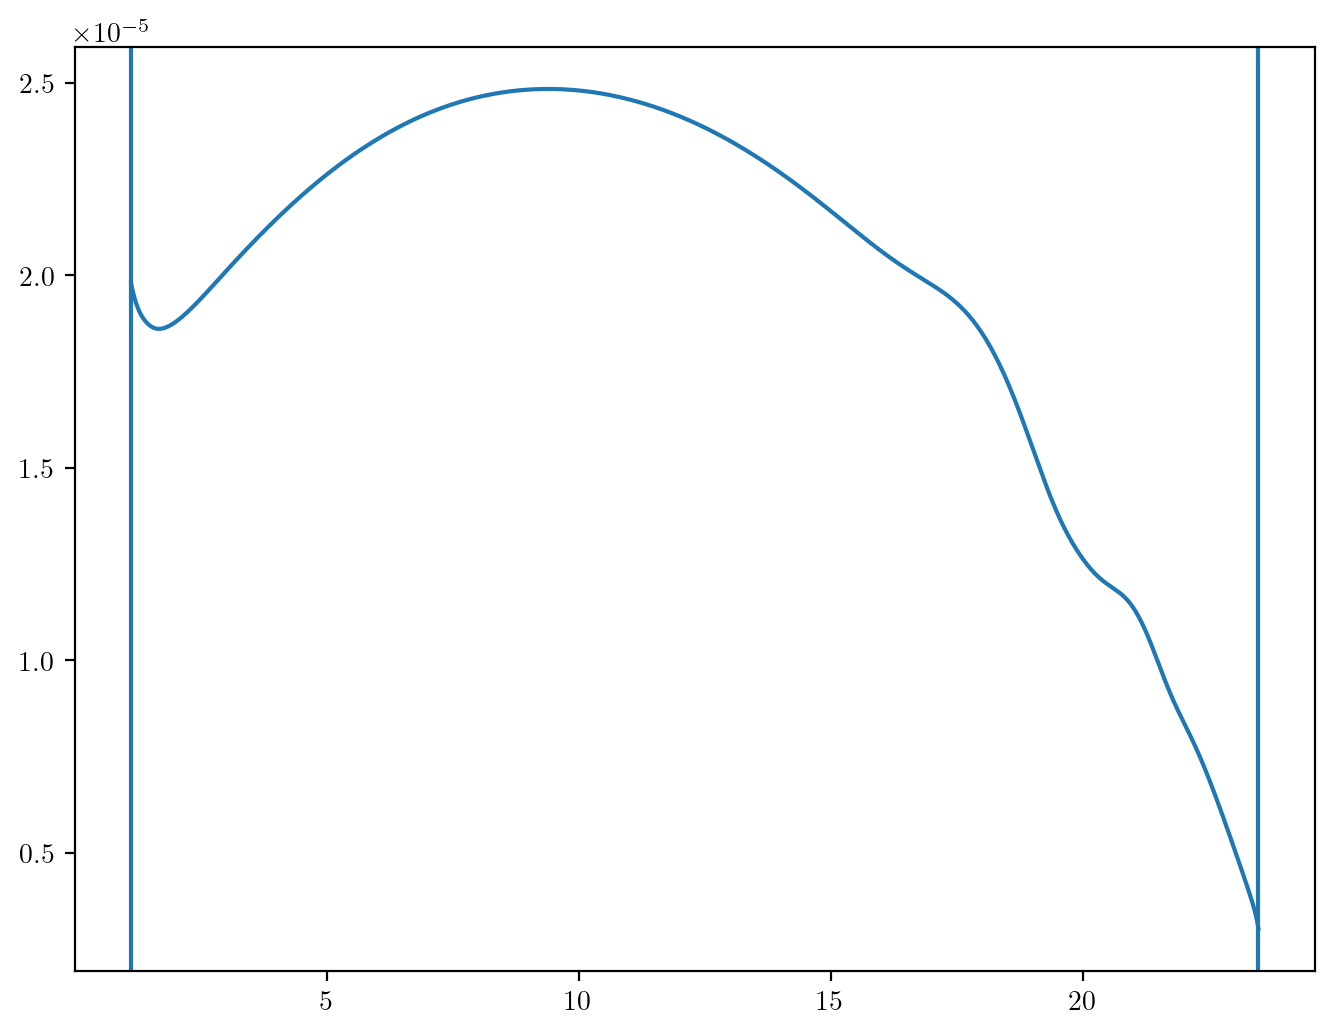

In [11]:
plt.plot(profile.radius.values[::-1][m], 
         1/profile.conv_vel.values[::-1][m])

# plt.plot(gyre['r'] * u.cm.to(u.R_sun), cs / α_MLT * np.sqrt(gyre['∇'] - gyre['∇ad']))
plt.axvline(rc_inner * u.cm.to(u.R_sun))
plt.axvline(rc_outer * u.cm.to(u.R_sun))

/home/joel/.local/lib/python3.10/site-packages/pandas-1.5.1-py3.10-linux-x86_64.egg/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1.1169493682423497, 23.483130132988503)

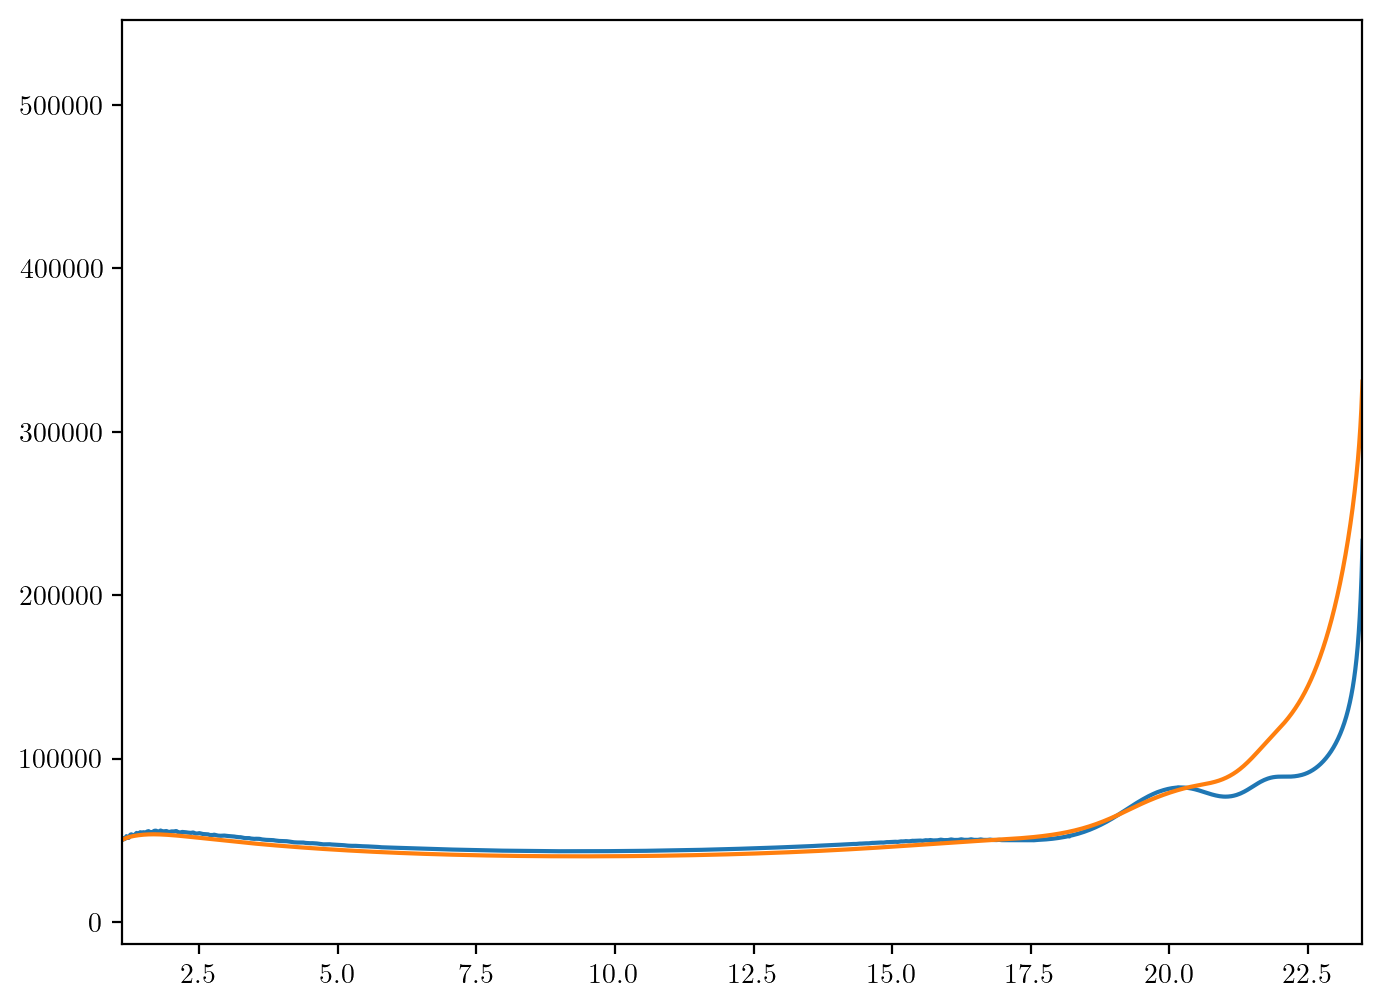

In [12]:
# plt.axvline(r0 * u.cm.to(u.R_sun))
# plt.axvline(rc * u.cm.to(u.R_sun))

cs = np.array(np.sqrt(gyre['Γ1'] * gyre['P'] / gyre['ρ']))
plt.plot(gyre['r'] * u.cm.to(u.R_sun), cs / α_MLT * np.sqrt(gyre['∇'] - gyre['∇ad']))
plt.plot(profile.radius.values[::-1][m], profile.conv_vel.values[::-1][m])

plt.xlim(rc_inner * u.cm.to(u.R_sun), rc_outer * u.cm.to(u.R_sun))

In [13]:
from astropy import units as u

Ro = 100 * u.d / (τ * u.s).to(u.d)
Ro

<Quantity 0.28207923>

In [23]:
m = (gyre['N2'] > 0) & (gyre['r']/info['R'] < .9)

print(np.max(gyre[m]['m']))
print(np.max(gyre[m]['m'])/info['M'])

print(np.max(gyre[m]['r']))
print(np.max(gyre[m]['r'])/info['R'])

print(info)

6.3057266469300555e+32
0.26957561304095295
53447783827.10982
0.032554051419315014
{'nrows': 3031.0, 'M': 2.3391309680420208e+33, 'R': 1641816655588.3152, 'L': 6.777587021480649e+35, 'version': 101.0}


In [25]:
gyre[['r','ρ']].to_csv("density.csv", index=False)